# **Sim-SOENs**
## ***A Simulator for Superconducting Optoelectronic Networks***

The *'Phenomenological Model for Superconducting Optoelectronic Loop Neurons'* paper upon which this simulator is built:
  - https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.013164

|Topic                    |Contact|
|-------------------------|-------|
|sim_soens, algorithms    | rmoloughlin11@gmail.com  |
|                         | ryan.oloughlin@nist.gov  |
|cicuits                  |bryce.primavera@nist.gov  |
|involvement opportunities|jeffrey.shainline@nist.gov|

# Introduction: *What are SOENs?*
<!-- ![ title](img/wafer_tilted.png) ![ title](img/neuron_3d.png) ![ title](img/neuron_complex.png) -->
![ title](../img/wafers_circuits.png)


 - **SOENs are an emerging neuromorphic hardware that leverage light-speed communication for brain level scalability.**
   - Developed at the National Institute for Standards and Technology (NIST) by:
     - Jeff Shainline
     - Jeff Chiles
     - Saeed Khan
     - Bryce Primavera
     - Ryan O'Loughlin
 - **SOENs are spiking neural networks**
   - Spikes --> photons
   - Neurons --> superconducting circuits
   - Transmitters --> silicon diode light source
 - **SOEN neurons are neuro-inspired**  
   - Sophisticated dendritic arbors for single-neuron computations

![ title](../img/neuron_complex.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from sim_soens.super_input import SuperInput
from sim_soens.super_node import SuperNode
from sim_soens.soen_sim import network
from sim_soens.super_functions import *
from sim_soens.soen_plotting import raster_plot, activity_plot

## Part 1: What is a SOEN Neuron?

A SOEN Neuron consists of three main components:
 - **Synapse**     = Single Photon Detector (SPD)
 - **Dendrite**   = Superconducting Quantum Interference Device (SQUID) as the *recieving loop* with an L/R circuit *integration loop*
   - *Somatic Dendrite*
     - Acts as the cell-body
     - Integrates signal from a preceding dendritic arbor, or directly from a synapse
     - When threshold is reached, activates transmitter circuit and couples flux to refractory dendrite
   - *Refractory Dendrite* (not shown here)
     - inhibits somatic dendrite through coupled flux 
   - *Arbor Dendrite* (not shown here)
     - An arbor can consist of arbirtrary multi-dendrite structures
     - All roads lead to soma
 - **Transmitter** = hTron coupled to a silicon light emitting diode which routes photonic output to downstream synapses via waveguides

![ title](../img/monosynaptic.png)

In sim-soens, conjuring up a neuron is best done through the `SuperNode` class
 - A node is an object that contains all components of a neuron
 - Hosts meta-data about the neuron
 - Stores post-simulation data about the neuron's activity
 - By default, a minimal neuron is created
   - One synapse
   - One soma (a dendrite with a transmitter and coupled refractory dendrite)

In [2]:
# call an instance of the SuperNode class
node = SuperNode()

# read about your node
node.parameter_print()


SOMA:
 ib_n = 1.802395858835221
 tau_ni = 50
 beta_ni = 628.3185307179587
 loops_present = ri
 s_th = 0.5
 synaptic_inputs = ['rand_neuron_77132_syn0']
 dendritic_inputs = ['rand_neuron_77132__dend_refraction']

REFRACTORY DENDRITE:
 ib_ref = 1.7
 tau_ref = 50
 beta_ref = 628.3185307179587
 loops_present = ri
 dendritic_inputs = []

DENDRITIC ARBOR:
  empty


### Input
 - Input is generally provided in the form of spike trains (spike = incoming photon)
 - Creating input is best done through the `SuperInput` class
   - Random
   - Defined
   - MNIST
   - Saaccade MNIST

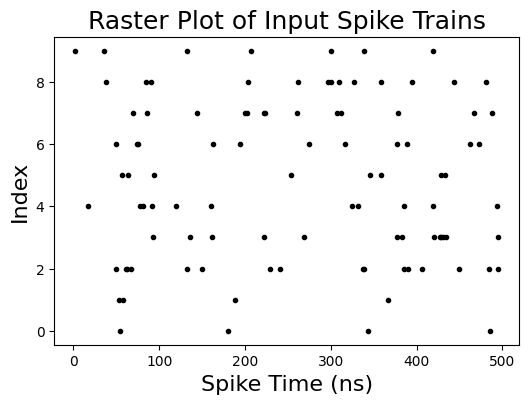

In [3]:
# random spike train for one input channel with ten spikes total over 100ns
input = SuperInput(channels=10, type='random', total_spikes=100, duration=500)
# raster_plot(input.spike_arrays, title='Raster Plot of Input Spike Trains')
title='Raster Plot of Input Spike Trains'
input.plot(title=title,notebook=True)

 - Adding the input to a neuron can be done with node methods
   - `uniform_input`: add a given spike train to all available synapses
   - `custom_input`: add a given spike train to specific synapses
   - `one-to-one`: channels and synapses of same index connected
   - `multi_channel_input`: define specific connectivity between multiple inputs and multiple synapses

In [4]:
# information about classes, methods, and functions can always be printed via
print(SuperNode.uniform_input.__doc__)


        uniform_input:
         - syntax -> SuperNode.uniform_input(SuperInput)
         - Adds the same input channel to all available synapses
         - note, the first channel of the SuperInput object will be used
        


### Simulation
- An input event creates a jump in current in the SPD synapse loop
- This causes flux to be coupled into the associated dendrite
  - In the case below, we are still using the default monosynaptic point neuron
  - Thus, the SPD synapse feeds into the soma directly
- Because here the coupling strength between the synapse and soma is 1 (by default), the shape of the SPD flux resposne can be observed as the plotted $\phi_r$ curve (flux recieved by the soma from the synapse)
-  ***Signal*** (a term from spin glass literature, but think ***membrane potential***) is integrated into the soma according to received flux
   -  The transfer function is non-trivial (though it appears so here) --> we will explore this later 

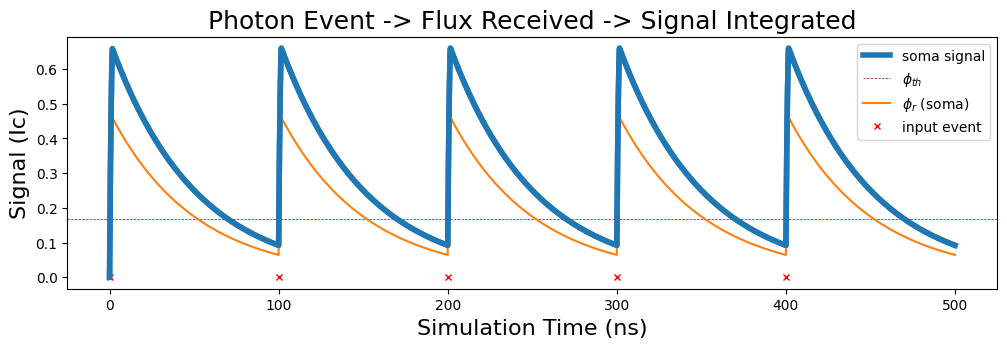

In [5]:
# spike times in nanoseconds
spike_times = np.arange(0,500,100) 

# if type=='defined': defined_spikes argument create 1-channel input object
input = SuperInput(type='defined', defined_spikes=spike_times)

# note, any neuron or dendrite parameters can be passed into the node class init
node = SuperNode(s_th=1) # large spiking threshold to avoid spiking for now

# adding input uniformly to available synapse on node's neuron
# in this case there is only one synapse attached to the somatic dendrite
node.uniform_input(input)

# create and simulate a (single node) network
net = network(
    sim   =True,            # run simulation
    tf    =input.duration,  # total duration (ns)
    nodes =[node]           # nodes in network to simulate
    )       

# plot neuron activity
title = 'Photon Event -> Flux Received -> Signal Integrated'
node.plot_neuron_activity(net,spikes=True,phir=True,input=input,title=title)


***Exercise!***
  - (1.1) Run the simulation a few times (random input spike trains will be generated each time)
    - Estimate the maximum frequency a synapse can recieve a new input event


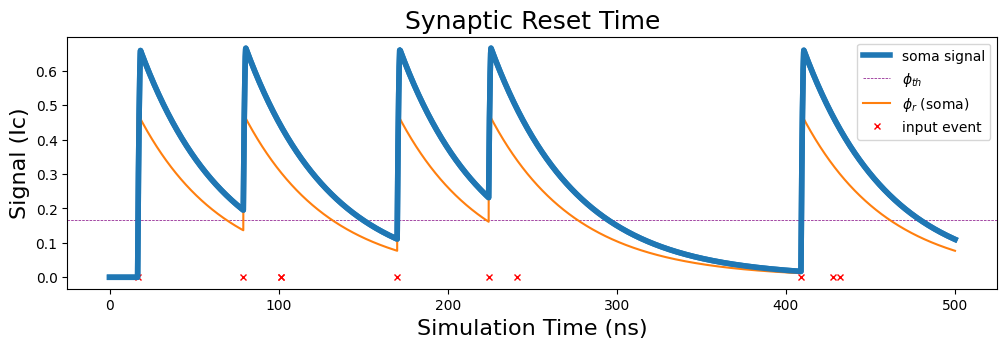

In [6]:
# random spike train for one input channel with ten spikes total over 100ns
input = SuperInput(channels=1, type='random', total_spikes=10, duration=500)

node = SuperNode(s_th=100)
node.uniform_input(input)
net = network(sim=True,dt=.1,tf=500,nodes=[node])
title = 'Synaptic Reset Time'
node.plot_neuron_activity(net,spikes=True,phir=True,input=input,title=title)

### Parameters
While there are many fabrication determined physical constants associated with a SOEN neuron, there are only three main dendritic parameters for moderating computation:
 - $i_b$ = `ib`   = bias current 
   - determines strength (and total possible amount) of integrated signal for a given input
 - $\tau$ = `tau`
   - the time constant associated with the leaking rate of signal from the integration loop
 - $\beta$ = `beta` 
   - inductor size in the integration loop (affecting shape of integration and leak curves)

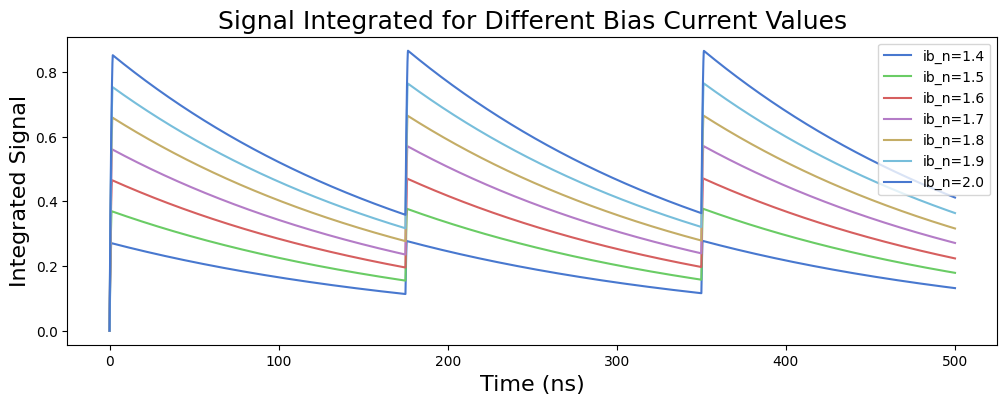

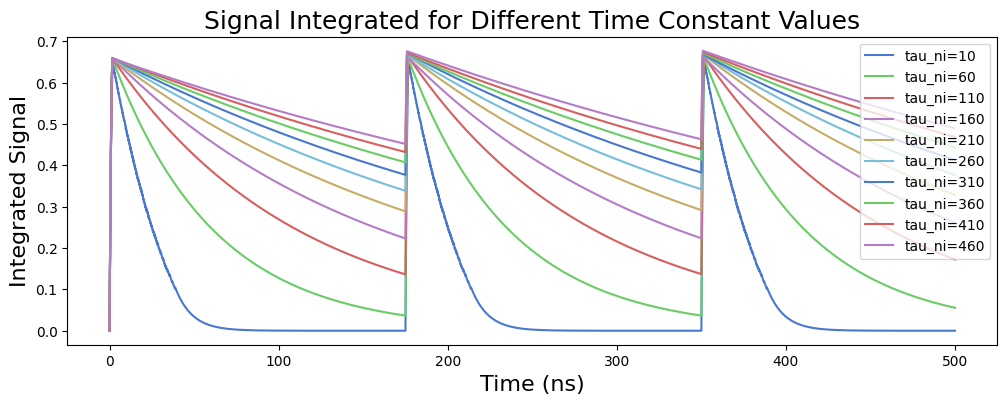

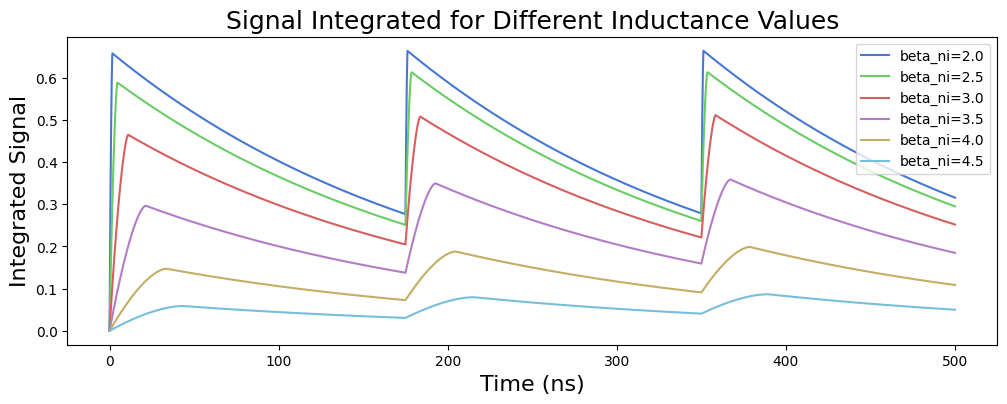

In [83]:
spike_times = np.arange(0,500,175)
input = SuperInput(type='defined', defined_spikes=spike_times)


param_lists = [
    np.arange(1.4,2.05,.1),
    np.arange(10,500,50),
    np.arange(2,5,.5)
    ]
names = ['Bias Current', 'Time Constant', 'Inductance']
code_names = ['ib_n','tau_ni','beta_ni']
for i,param_list in enumerate(param_lists):
    plt.figure(figsize=(12,4))
    for p in param_list:
        params = [1.8,200,2]
        params[i] = p

        node = SuperNode(
            s_th    = 1,                     # spiking threshold    
            ib_n    = params[0],             # bias current         
            tau_ni  = params[1],             # time constant        
            beta_ni = 2*np.pi*10**params[2], # inductance parameter 
            ) 
        node.uniform_input(input)
        net = network(sim=True,dt=.1,tf=500,nodes=[node])
        label = f"{code_names[i]}={round(p,2)}"
        plt.plot(net.t,node.neuron.dend_soma.s,label=label)
    plt.title(f'Signal Integrated for Different {names[i]} Values',fontsize=18)
    plt.xlabel('Time (ns)',fontsize=16)
    plt.ylabel('Integrated Signal',fontsize=16)
    plt.legend(loc=1)
    plt.show()
    params = [1.8,400,2]

***Exercise!***
 - (1.2) Play with the below node parameters 
   - In this case, these are somatic dendrite params (denoted by _ni suffix)
 - (1.3) Attempt to get zero,five, and ten output spikes for your random input spike train!
   - Best done with combinatinos of change
   - *Bonus Challenge --> Achieve 0,5,and 10 spikes while only changing one parameter at a time (holding the rest constant) for all parameters*
 - (1.4) Try to define the influence of each parameter
 - (1.5) Understand the role of the red line (refractory dendrite signal)

*Hint --> See subsequent information slide*

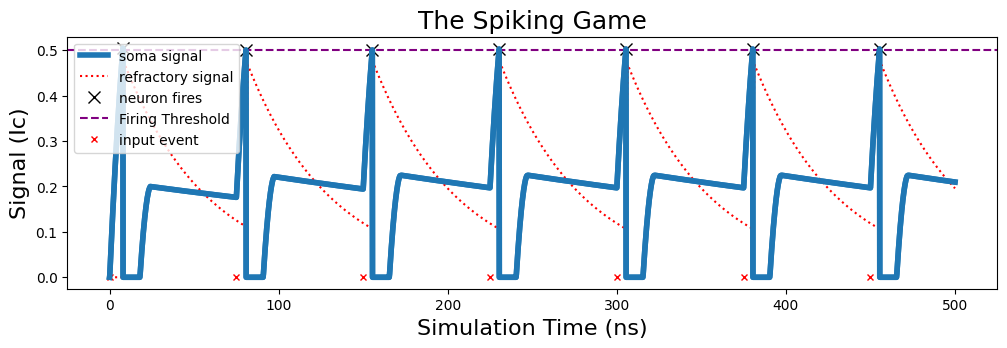

In [8]:
spike_times = np.arange(0,500,75)
input = SuperInput(type='defined', defined_spikes=spike_times)

node = SuperNode(
    s_th    = .5,           # spiking threshold    (you choose)
    ib_n    = 2.05,         # bias current         (realistically, must be between 1.4 and 2.05)
    tau_ni  = 400,          # time constant        (and positive value)
    beta_ni = 2*np.pi*1e3,  # inductance parameter (just change the exponent)
    ) 

node.uniform_input(input)
net = network(sim=True,dt=.1,tf=500,nodes=[node])
node.plot_neuron_activity(net,ref=True,spikes=True,input=input,title='The Spiking Game')

#### The Phenomenological Model

These parameters influence signal integration for any given dendrite according to:
\begin{equation*}
\beta \frac{ds}{dt} = r(\phi,s,i_b)) - \alpha s
\end{equation*}
which is implemented in the code via the forward euler method as:
\begin{equation*}
s_{t+1} = s_t(1-\Delta t\frac{\alpha}{\beta}+\frac{\Delta t}{\beta} r(\phi,s,i_b))
\end{equation*}

The above equation determines the dynamics of all SOEN dendrites and therefore of the model at scale.  We call it the *phenomenological model* because it executes behavior that is qualitatively analogous ($\chi^2$ error of $10^{-4}$) to the true circuit equation solutions at a speed ($10^4$) faster!


Note, we use the `_ni` suffix for the soma-associated dendrite specifically and the `_di` for all arbor dendrites.

The rate array $r(...)$ is a function of: 
 - $s$ = accumulated signal in the dendritic integration loop at the previous time step
 - $\phi_r$ =  received flux via couplings into the dendritic recieving loop
 - $r_{fq}$ = flux quantum production (fluxons emmitted from receiving loop to integration loop)

![ title](../img/dendrite.png)


The rate array $r(\phi,s,i_b)$ itself refers to pre-derived circuit equation solutions that take the form of a three-dimensional surface (see below image).  `s` and `phi_r` are used to reference `r_fq`, which determines the new signal to be added (via fluxons) into the dendritic integration loop.  We see that for greater values of $s$, there is less flux quantum production for the same received flux $\phi_r$.  This is because the loop approaches *saturation*.

We also see that for different values of $i_b$, greater $r_{fq}$ values can be achieved for equivalent $s$ and $\phi_r$ values because the saturation limit is rasied.

![ title](../img/rate_arrays.png)

### Saturation
***Exercise!***
 - (1.6) Run the code below and observe that signal integration approaches a limit.  Is this a balance of input/decay rate or true signal saturation.  What parameter can be changed to ensure saturation is reached?  What is the saturation value (max integrateable signal)?
   - **hint -> We want to be sure that the signal is not simply leaking at about the same frequency that is being integrated*

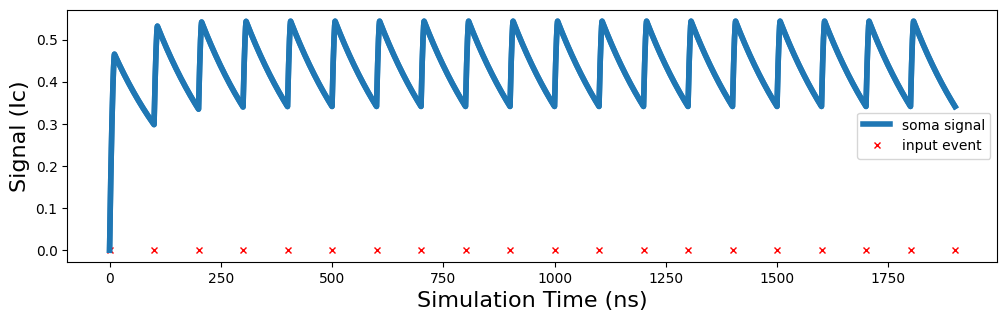

In [9]:
spike_times = np.arange(0,2000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))

node = SuperNode(
    s_th    = 100,          # spiking threshold    
    ib_n    = 1.8,          # bias current         
    tau_ni  = 200,          # time constant #**10
    beta_ni = 2*np.pi*1e3,  # inductance parameter
    ) 

# all (there's only one) synapses get the same input
node.uniform_input(input)

# create and simulate (single neuron) network
net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node])

# plot activity
node.plot_neuron_activity(net,spikes=True,input=input)

### Rollover
- `w_sd` = coupling strength between synapse and dendrite (in this case the soma)

***Exercise!***
 - (1.7) Analyize the following image and then run the code.  Given our new parameter, signal integration may not behave as expected as compared to the control neuron.  Can you explain why?
 - (1.8) Play around with different values of `ib_n` and `w_sd` for the rollover node.  Pay attention to the $\phi_{th}$ line.  What does it demarcate?

![ title](../img/phi_period.png)

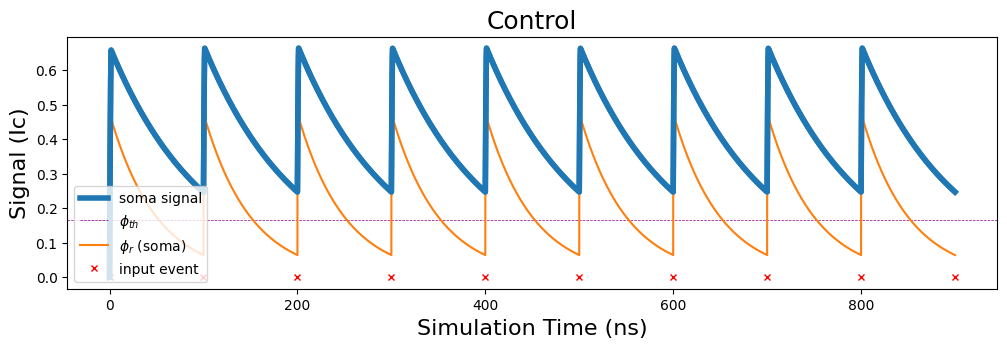

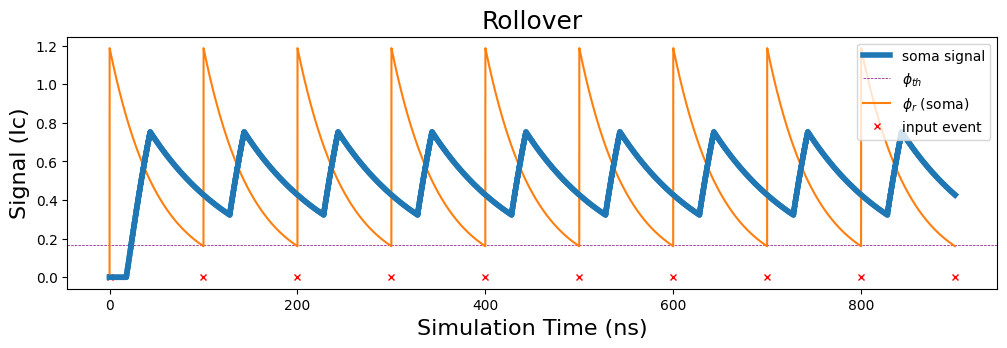

In [10]:
spike_times = np.arange(0,1000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))

# An example of a node without rollover (all same params, except w_sd)
node_control = SuperNode(s_th=1,ib_n=1.8,tau_ni=100) 
node_control.uniform_input(input)
net_control = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node_control])
node_control.plot_neuron_activity(
    net_control,spikes=True,input=input,phir=True,ref=False,title='Control'
    )

# Rollover Node
rollover_node = SuperNode(s_th=100,tau_ni=100, # extra params
                 
    ib_n = 1.8, # bias current (must be between 1.4 and 2.05)
    w_sd = 2.5, # determines coupling strength of synapse to dendrite

    ) 

rollover_node.uniform_input(input)
rollover_net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[rollover_node])
rollover_node.plot_neuron_activity(
    rollover_net,spikes=True,input=input,phir=True,ref=False,title="Rollover"
    )

![ title](../img/phi_period.png)

## Part 2: Dendritic Arbors
 - Biological neurons are much more than a soma and a synapse!
 - SOEN neurons therefore incorporate potentially large dendritic structures
 - This allows for complex computations to occur at the single neuron level!

### Building Structure
 - Using `SuperNode`, arbitrary dendritic trees (or arbors) can be built
 - Simply pass in a `weights` argument and a dendritic tree will be built with this shape
   - [layer][group][dendrite]
   - This is meant to be visually intuitive
   - *The group number in defines which downstream dendrite in the next layer the dendrites will feed to*
 - Each value in `weights` determines the coupling strength of that connection

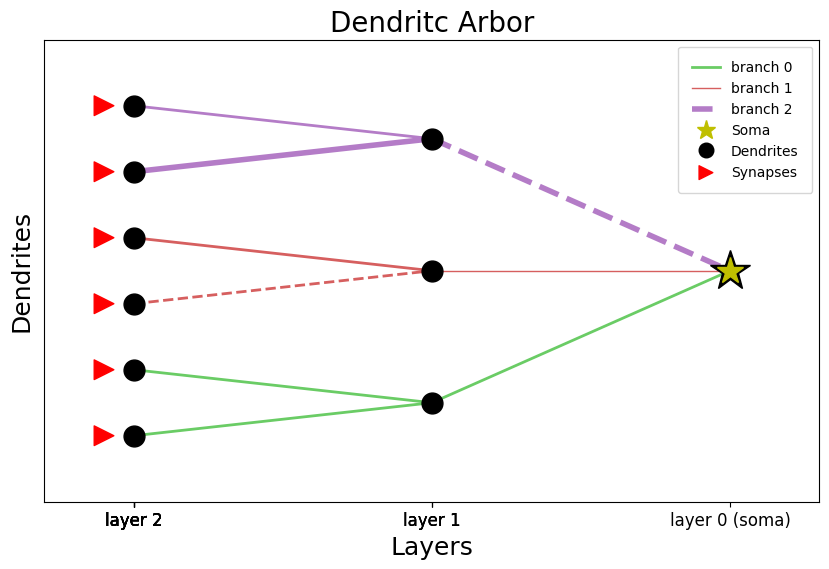

[[<sim_soens.soen_sim.dendrite object at 0x00000245A4AC8EB0>]]
[[<sim_soens.soen_sim.dendrite object at 0x00000245A4B2CE80>, <sim_soens.soen_sim.dendrite object at 0x00000245A341B0D0>, <sim_soens.soen_sim.dendrite object at 0x00000245A341AD10>]]
[[<sim_soens.soen_sim.dendrite object at 0x00000245A4A98A60>, <sim_soens.soen_sim.dendrite object at 0x00000245A4A985B0>], [<sim_soens.soen_sim.dendrite object at 0x00000245A4A9B0D0>, <sim_soens.soen_sim.dendrite object at 0x00000245A4A9B460>], [<sim_soens.soen_sim.dendrite object at 0x00000245A4A98D00>, <sim_soens.soen_sim.dendrite object at 0x00000245A4A99AE0>]]


In [11]:
# define weights, 
weights = [
    [[0.4,.3,-.8]],             # 1rst layer, 1 group, 3 dendrites (one group max in first layer)
    [[.5,.5],[-.5,.5],[.9,.5]]  # 2nd layer, 3 groups, 2 dendrites per group
    ]

# SuperNode will construct a neuron with this dendritic structure
node = SuperNode(weights=weights)

# Check the structure is as intended!
node.plot_structure()

# SuperNode.dendrites is a list of lists in the form of `weights`, containing dendrites
# IMPORTANT: SuperNode.dendrites has automatically added the soma-dendrite to the 0th layer
for layer in node.dendrites:
    print(layer)

In [12]:
# To access dendrites from outside the node, index accordingly
# [layer][group][dendrite]
print(node.dendrites[2][1][0].name)

# Remember the soma is at 0-0-0
print(node.dendrites[0][0][0].name)

rand_neuron_30182_lay2_branch1_den0
rand_neuron_30182_soma


*Exercise!*
 - (2.1) Build a neuron with a structure of 3 dendrites in the first layer, and a different number of dendrites feeding into each of the first layer dendrites from the second layer.
 - (2.2) Build a neuron with three layers

In [13]:
# # define weights, 
# weights = [
#     [[]],       # first layer, ONLY ONE GROUP EVER
#     [[],[],[]]  # second layer, usually as many group as dendrites in layer 1
#     ]

# # SuperNode will construct a neuron with this dendritic structure
# node = SuperNode(weights=weights)

# # Check the structure is as intended!
# node.plot_structure()

### Synaptic Structure
 - Mostly, we would like to simply use the default synaptic layer at the outermost dendrite of the tree
 - However, biologically, synapses can be located along dendritic branches
 - If custom synaptic structure are desired, a list of arbor structures (now including one extra preceding layer for the soma) can be included to define synapse locations and strengths.  One structure per synapse.

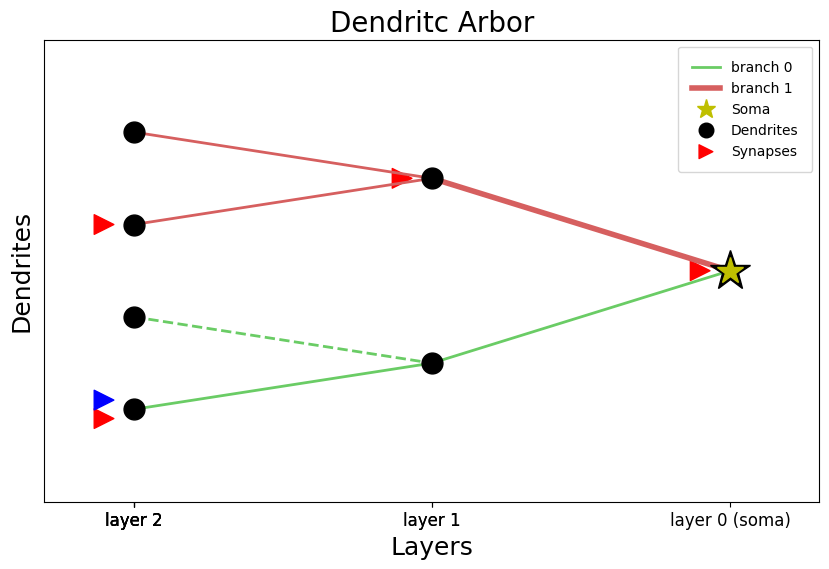

In [14]:
weights = [
    [[0.4,.8]],
    [[.5,-.5],[.5,.5]]
    ]

syn_struct = [

    # first synapse -- connected to first dendrite of first group in outer-layer
    [[[0]],
    [[0,0]],
    [[1,0],[0,0]]],

    # second synapse -- same place, but inhibitory
    [[[0]],
    [[0,0]],
    [[-1,0],[0,0]]],

    # third synapse -- first dendrite of second group in last layer
    [[[0]],
    [[0,0]],
    [[0,0],[1,0]]],

    # fourth synapse -- second dendrite of middle layer
    [[[0]],
    [[0,1]],
    [[0,0],[0,0]]],

    # fifth synapse -- directly connected to the soma-dendrite
    [[[1]],
    [[0,0]],
    [[0,0],[0,0]]],

]

node = SuperNode(
    weights=weights,
    synaptic_structure=syn_struct
    )

node.plot_structure()

 - for more concise synapse generation use `synaptic_indices` and `synaptic_strengths`

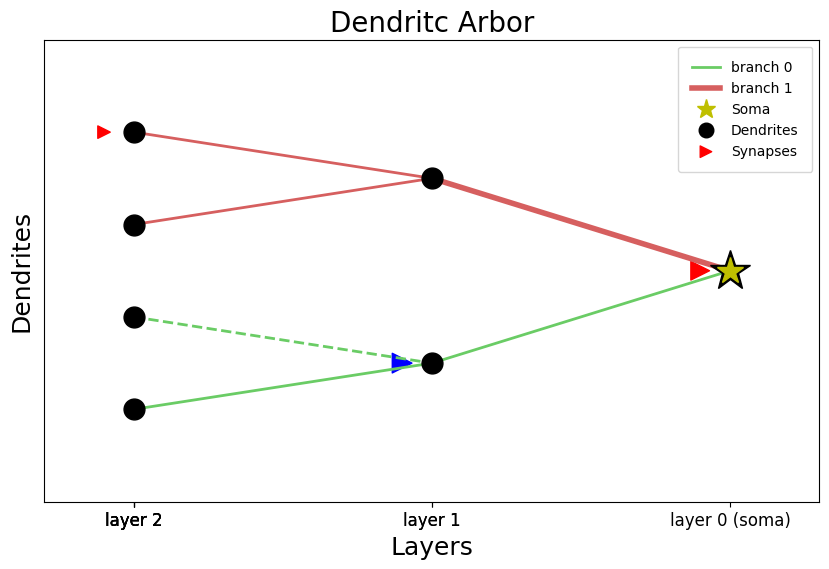

In [15]:
weights = [
    [[0.4,.8]],
    [[.5,-.5],[.5,.5]]
    ]

# to which dendrite indices are synapses attached
s_indices = [
    [0,0,0],
    [1,0,0],
    [2,1,1]
]

# and with what strengths (1 by default)
s_strengths = [
    .9,
    -1,
    .4
    ]


node = SuperNode(
    weights=weights,
    synaptic_indices=s_indices,
    synaptic_strengths=s_strengths
    )

node.plot_structure()


*Exercise*
 - (2.2) Place a synapse at every dendrite

In [16]:
# weights = [
#     [[0.4,.8]],
#     [[.5,-.5],[.5,.5]]
#     ]

# s_indices = [
#     [0,0,0],
#     [1,0,0],
#     [2,1,1]
# ]

# s_strengths = [
#     .9,
#     -1,
#     .8
#     ]


# node = SuperNode(
#     weights=weights,
#     synaptic_indices=s_indices,
#     synaptic_strengths=s_strengths
#     )

# node.plot_structure()

### Arbor Activity
 - Rather than imagining how information propagates accross the dendrit tree, we use `SuperNode.plot_arbor_activity(net)` to observe the recorded signal (and optionally flux) at each dendrite for a simulation.
 - This has turned out to be one of the most-used development tools
 - Note, the main (soma terminating) branches are color coded

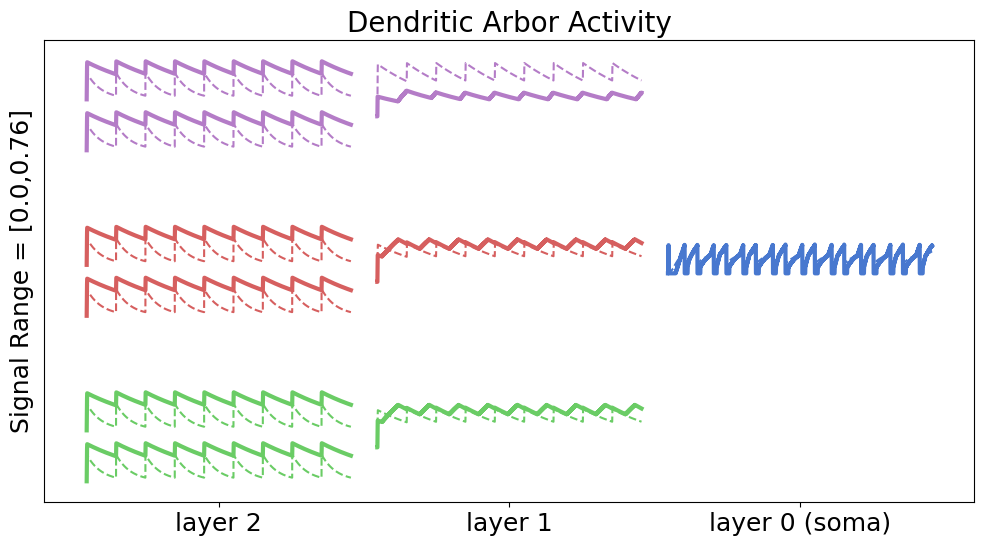

In [17]:
spike_times = np.arange(0,1000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))
weights = [
    [[0.4,.3,.2]],
    [[.5,.5],[.5,.5],[.9,.5]]
    ]
node = SuperNode(weights=weights)
node.uniform_input(input)
net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node])
node.plot_arbor_activity(net,phir=True)

### Logic Gates
Equipped with integration and structure, collections of dendrites can instantiate logical operations.  Here we refer to the truth values of incoming photons to two separate synapses.

|Logic |Truth                                         |
|----- |-----                                         |
|AND   |Simultaneous arrival                          |
|OR    |Either (or simultaneous) arrival              |
|XOR   |Only one arrives at a time (not simultaneous) |
|AND-OR|Specifcally one arrives and not the other     |

***Exercise!***
 - (3.1) Try inventing an AND gate such that the neuron only fires when receiving input at both synapses simultaneously
 - (3.2) Now try inventing the XOR gate! **Hint*, you will have to apply the concepts of inhibiton, refraction, and negative spikes to do this cleanly (one spike per truth value).

Output spike times:  [  51.5  501.5 1001.  1011.6 1022.3]


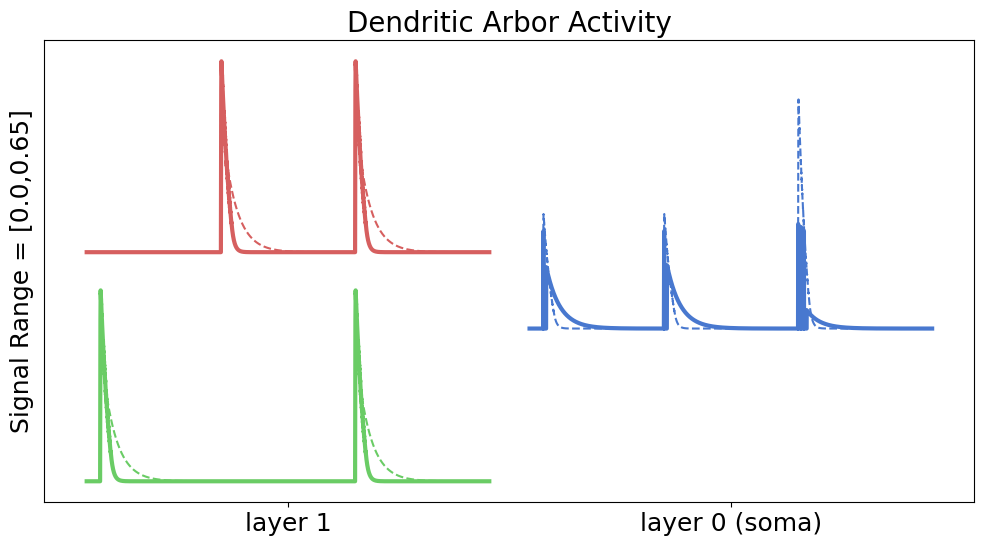

In [18]:
times = [50,500,1000,1000]
indices = [0,1,0,1]
def_spikes = [indices,times]
input = SuperInput(channels=2, type='defined', defined_spikes=def_spikes, duration=400)
# from soen_plotting import raster_plot
# raster_plot(input.spike_arrays)

weights = [
    [[.6,.6]],
    ]
taus = [
    [[10,10]],
    ]

# weights = [
#     [[0.4,.4]],
#     ]
# taus = [
#     [[10,10]],
#     ]

# weights = [
#     [[-.5,.5]],
#     ]
# taus = [
#     [[10,10]],
#     ]

connect = [[0,0],[1,1]]


# synaptic layer automatically draped over outer-most dendrites
node = SuperNode(s_th=.33,weights=weights,taus=taus,ib_ref=1)
node.multi_channel_input(input,connect)
net = network(sim=True,dt=.1,tf=1500,nodes=[node])
print("Output spike times: ",net.spikes[1])
# node.plot_neuron_activity(net,phir=True,legend=True) # useful for XOR
node.plot_arbor_activity(net,phir=True)

### 9-Pixel Classifier

Here is an analitic solution to the 9 pixel probelm from the phenomenological paper, using the dendrtic structure of a single SOENs neuron.  Note, that *OR-gates* and the *AND-OR-gates* are achieved with with a different type of dendrite that has a flat-top response (same signal integrated for 1 or 2 inputs).  This is simply an example dendritic processing in SOENs.

![ title](../img/9pixel.png)

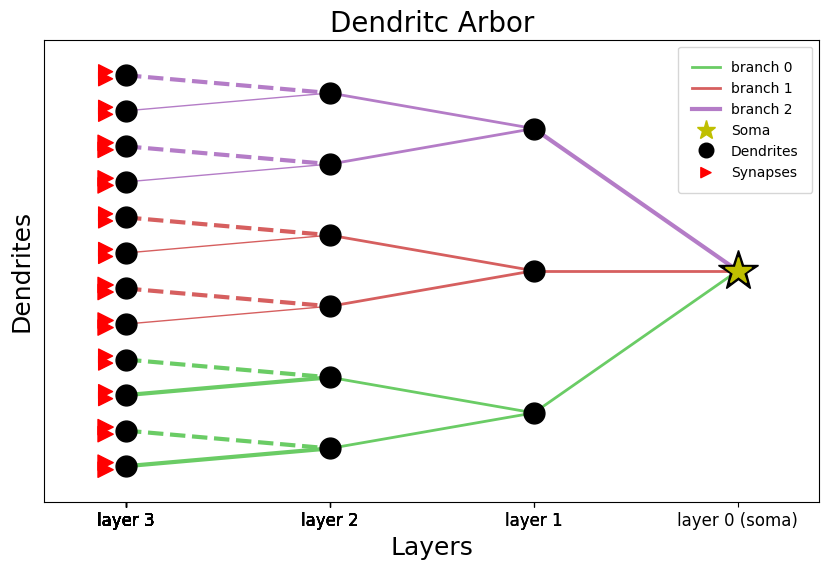

In [19]:
# here we see that not only weights can be passed in according to the abor-form,
# but also `taus`, `biases`, and `types` (dendrite type)
# not shown is also the `betas` option
params = {
    
    'weights': [
        [[.5,.4,.6]],
        [[0.5,0.5],[0.5,0.5],[0.5,0.5]],
        [[0.65,-0.65],[0.65,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65]]
    ],

    # the time constant at every dendrite
    'taus': [
        [[10,150,1000]],
        [[250,250],[250,250],[250,250]],
        [[250,250],[250,250],[250,250],[250,250],[250,250],[250,250]]
    ],

    # numbervalues refer to indices of a list of bias values for which 
    # rate-arrays have been generated
    'biases': [
        [[3,3,3]],
        [[5,5],[5,5],[5,5]],
        [[-4,3],[-4,3],[-4,3],[-4,3],[-4,3],[-4,3]]
    ],

    # defines dendrite type for each dendrite
    'types': [
        [['rtti','rtti','rtti']],
        [['ri','ri'],['ri','ri'],['ri','ri']],
        [['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri']]
    ],

    # input from this (number) channel goes to the (index position) synapse
    'syns': [['2','5'],['4','6'],['5','8'],['4','6'],['1','3'],['7','9'],
             ['4','6'],['2','5'],['7','9'],['1','3'],['4','6'],['5','8']],

    # with this associated weight
    'syn_w': [[.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5],
              [.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5]],
       
    # other neuron and denrite parameters
    "tau_di": 250,
    "ib_n"  : 1.5523958588352207, 
    "tau_ni": 50,
    "ib_ref": 1.7523958588352209, 
}


# create a neuron with this structure and parameters
nine_neuron = SuperNode(s_th=.1,**params) 
nine_neuron.plot_structure()

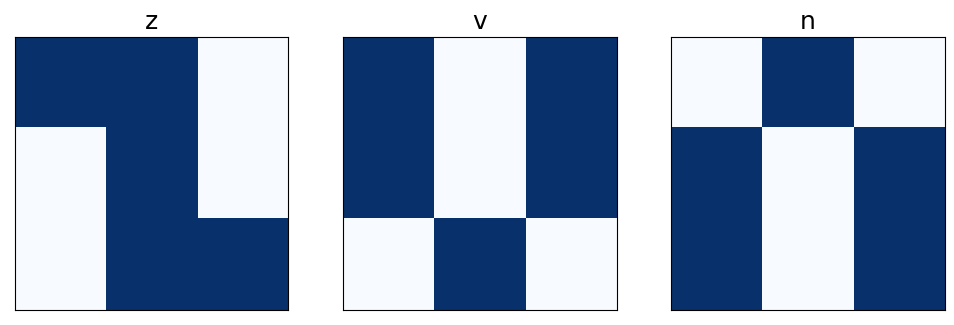

In [20]:
letters=make_letters()
inputs = make_inputs(letters,20)
plot_letters(letters)

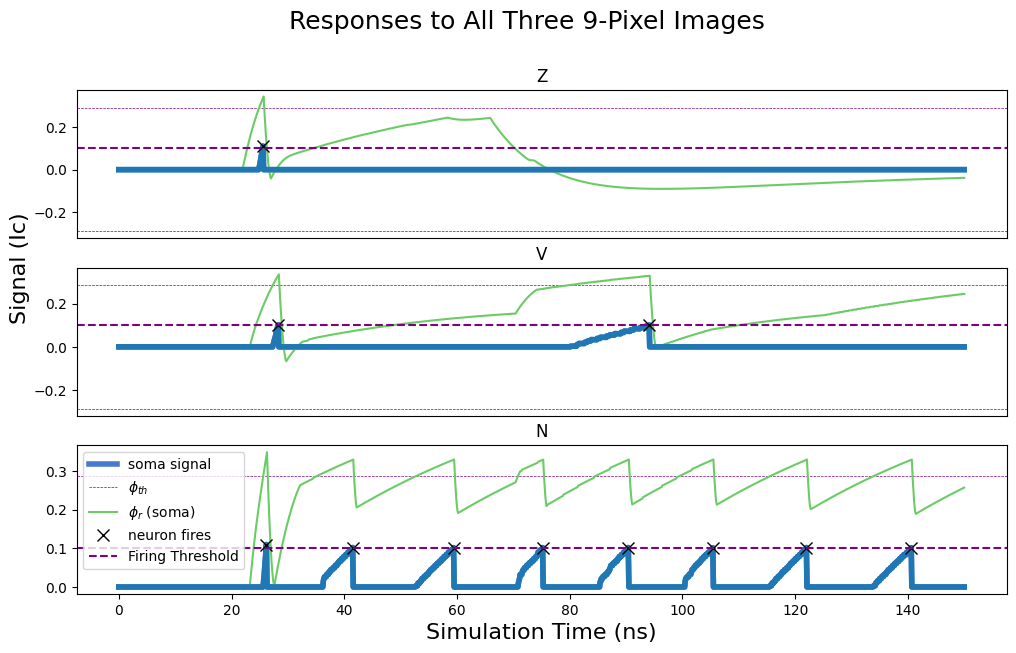

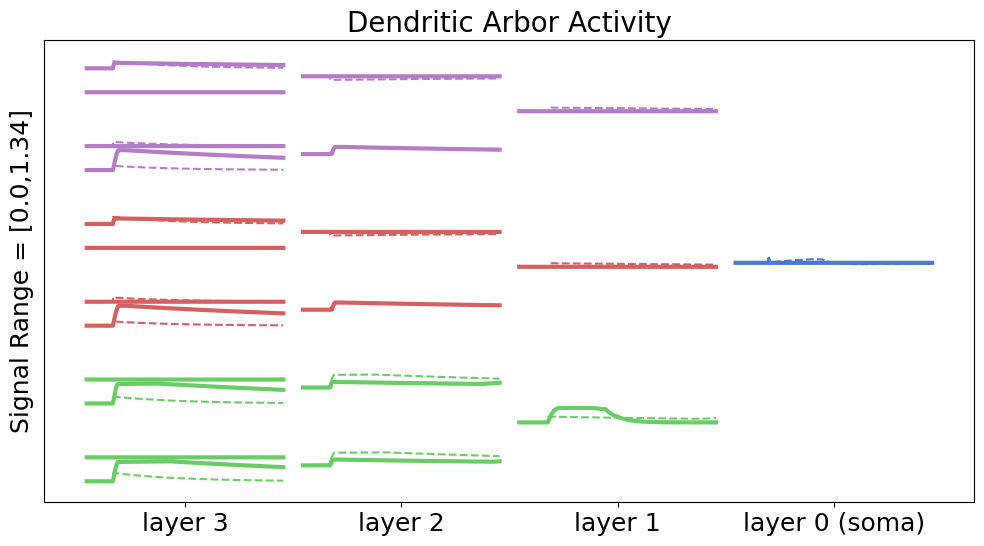

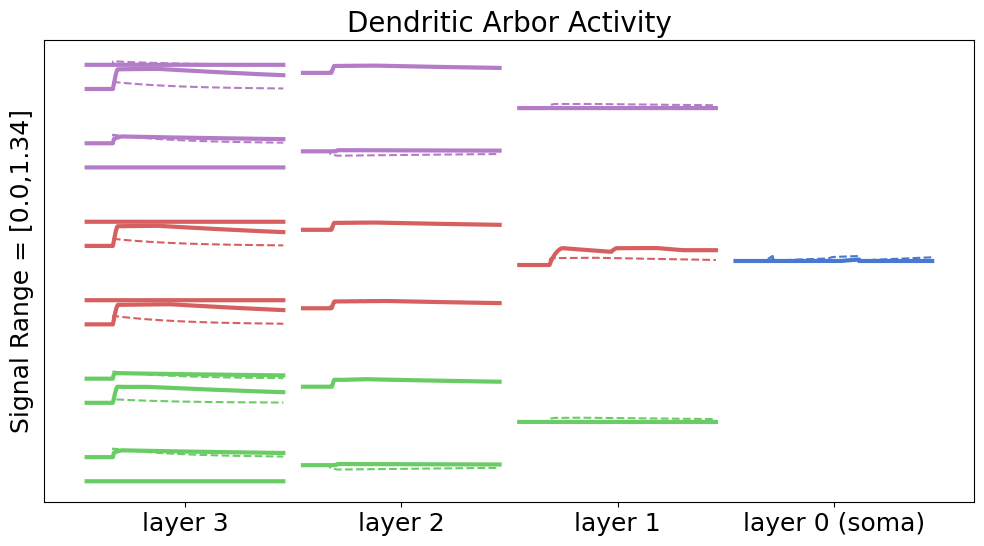

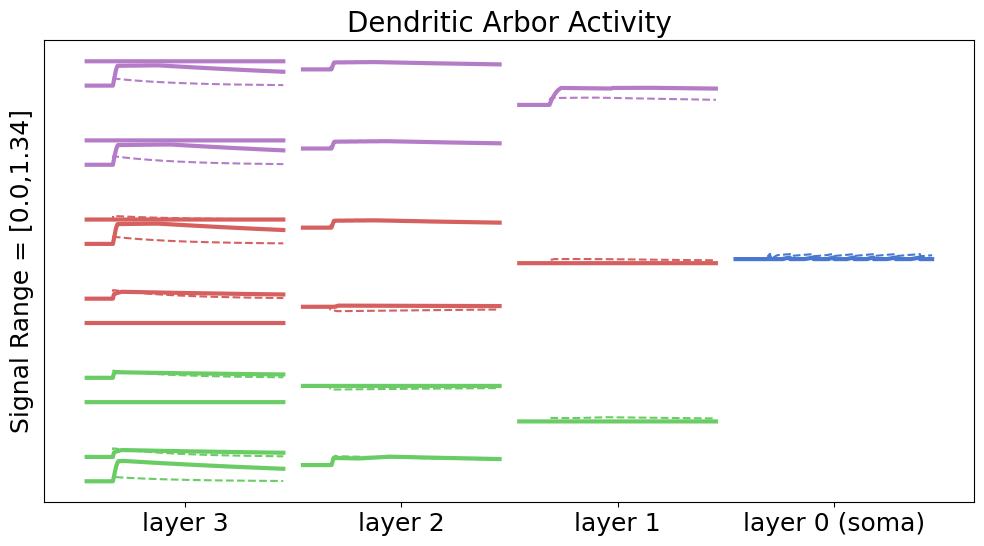

In [22]:
# for saving neuron states
run_neurons = []

# test on letters
for i,let in enumerate(letters):

    # make a nine-pixel classifier neuron
    nine_neuron = SuperNode(s_th=.1,**params) 

    # letter defined input
    input = inputs[i]

    # add input channels to appropriate synapses
    # this has since been automated
    count = 0
    for g in nine_neuron.synapses:
        for s in g:
            for i,row in enumerate(input.spike_rows):
                if i == int(s.name)-1:
                    s.add_input(input.signals[i])
                    count+=1
    run_neurons.append(nine_neuron)

# run all neurons simultaneously
net = network(sim=True,dt=.1,tf=150,nodes=run_neurons,null_synapses=False)

# plot!
title = 'Responses to All Three 9-Pixel Images'
subtitles =['Z','V','N']
activity_plot(run_neurons,net,dend=False,phir=True,size=(12,8),title=title,subtitles=subtitles)

for n in run_neurons:
    n.plot_arbor_activity(net,phir=True)

## Part 3: Plasticity
SOENs host a number of plasticity mechanisms through which the effective weight (a combination of coupling strength and bias current) between components can be moderated in real time according to any of the following:
 - Top down supervision
 - Automated hardware-in-the-loop
 - On-chip circuits responding to real-time local states
   - Memory loops!

Today, we will explore the most straightforward of our plasticity knobs--*flux offset*, which simply couples additional flux (positive of negative) to the receiving loop of a component such that for the same input relationship, different responses can be achieved.  Essentially, the 'weight' between that component and the subsequent downstream component can be tuned.

Below is a neuron with one synapse, one arbor-dendite, and a soma (synapse -> dendrite -> soma).  The dendrites flux is offset with different phi values.  Observe how this changes the *dendrite's* integrated signal.

***Exercise!***
 - (3.1) Run the cell and observe the inegrated signal for the dendrite. How do you predict this will change the integrated signal of the soma?  Plot to confirm.
 - (3.2) How will bias current moderate this change?  What are the total contributions to effective weight?  Try plotting different combinations.

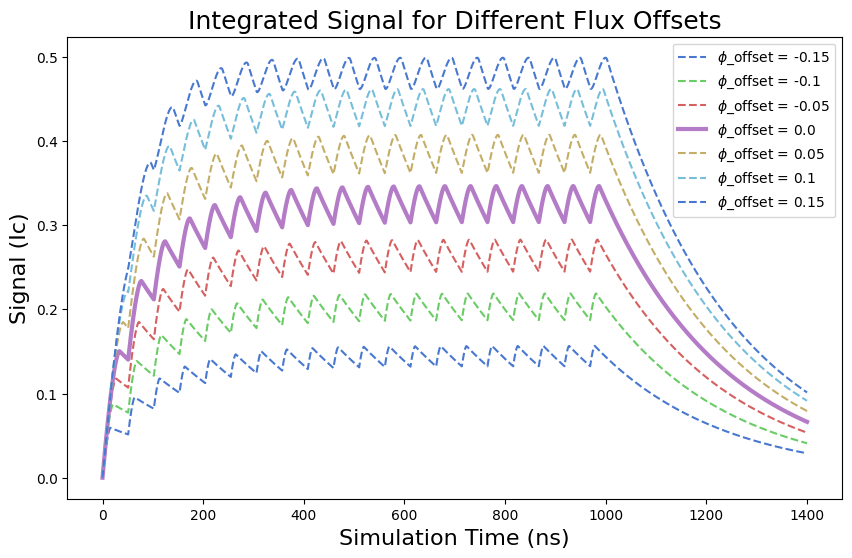

In [ ]:
# input
times = np.arange(0,1000,51)
input = SuperInput(channels=1, type='defined', defined_spikes=times)

# single dendrite between synapse and soma
weights = [[[0.5]]]

# make neuron and add input
mono_dend = SuperNode(
    weights=weights,s_th=1,beta_di=2*np.pi*1e4,tau_di=250,ib_n=1.8
    )
mono_dend.uniform_input(input)

# run simulations several times for different flux offset values
plt.figure(figsize=(10,6))
PHI = np.arange(-.15,.16,.05)
for phi in PHI:

    # changing flux offset of intermediate dendrite (not soma)
    mono_dend.dendrites[1][0][0].offset_flux = phi 
    net = network(sim=True,dt=.1,tf=1400,nodes=[mono_dend])
    
    # plot!
    if np.round(phi,2) == 0.0:
        plt.plot(
            net.t,mono_dend.dendrites[1][0][0].s,
            label=f'$\phi$_offset = {np.round(phi,2)}',
            linewidth=3
            )
    else:
        plt.plot(
            net.t,mono_dend.dendrites[1][0][0].s,'--',
            label=f'$\phi$_offset = {np.round(phi,2)}',
            # linewidth=4-(np.abs(phi)*10)**2
            )
plt.legend()
plt.xlabel("Simulation Time (ns)",fontsize=16)
plt.ylabel("Signal (Ic)",fontsize=16)
plt.title("Integrated Signal for Different Flux Offsets",fontsize=18)
plt.show()

### Learning!

One of the major benefits of dendritic process is that ***information is retained*** even after spiking events.  Unlike point neurons, dendrites hold integrated value with some leak rate for potentially long periods after the soma has spiked and extinguished all memory of pre-spike information.  ***Retained dendritic signal can be leveraged to make appropriate weight updates toward a learning task.***

In the below example, we demonstrate this key asset in its simplest form on the simplest of tasks.  We once again compute the solution to the 9-pixel problem, but now plasticity updates that are a function of error and dendrite state (at some learning rate) enacted on every dendrite after each letter input.  Note, this can be achieved with circuits on chip.

Training Z-neuron.  
Desired output = [0, 2, 4]

Run    Spikes
       [z, v, n]
0      [1, 1, 1]
5      [1, 1, 0]
10     [0, 1, 1]
15     [2, 2, 2]
20     [1, 1, 9]
25     [0, 8, 8]
30     [1, 2, 5]
Converged! (on run 32)
Spikes = [0, 2, 4]


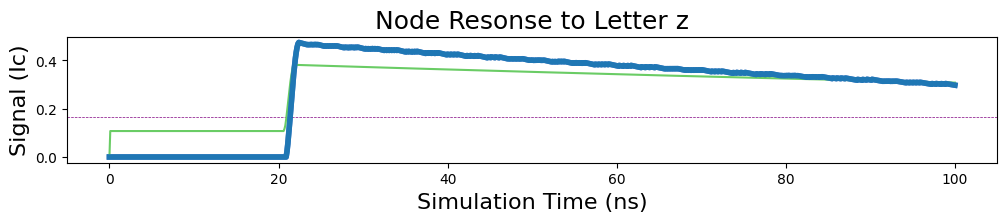

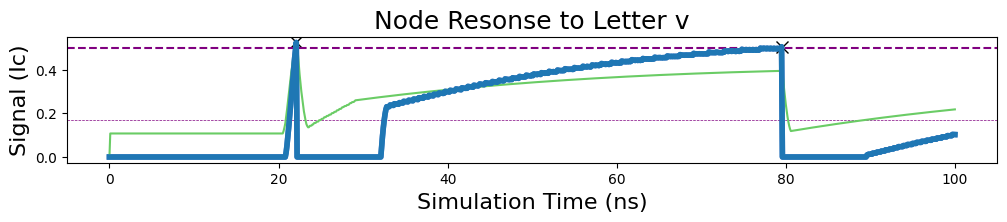

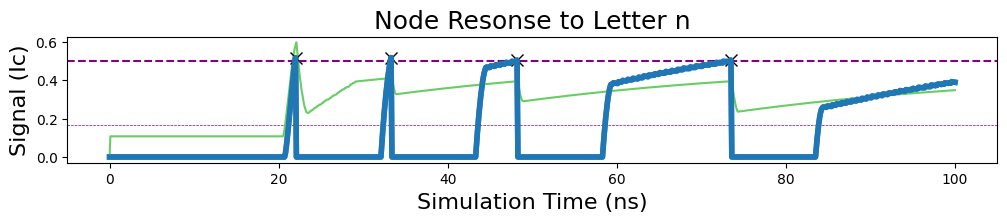

In [23]:
def single_9pixel_classifier(inputs,expect,learning_rate):
    import copy

    # make the neuron (initialize within dynamical range)
    weights = [
        [[.5,.5,.5]],
        [[.3,.3,.3],[.3,.3,.3],[.3,.3,.3]]
    ]
    node_z = SuperNode(weights=weights)


    # track flux offset trajectories for each dendrite
    offsets = {}
    for dend in node_z.dendrite_list:
        if 'ref' not in dend.name:
            offsets[dend.name] = []


    print("Training Z-neuron.  \nDesired output = [0, 2, 4]\n")
    print("Run    Spikes")
    print("       [z, v, n]")


    # give plenty of runs to converge
    for run in range(300):

        # track total error for each letter
        total_error=0
        plots = []
        act_plots = []
        spikes = []
        run_copies = []
        net_copies = []
        
        # iterate over each letter
        for i,input in enumerate(inputs):
            node_z.one_to_one(input)

            # run the simulation and count the spikes
            net = network(sim=True,dt=.1,tf=100,nodes=[node_z])
            out_spikes = net.spikes[1]
            spikes.append(len(out_spikes))

            # copy states of nodes for later plotting if converged
            run_copies.append(copy.deepcopy(node_z))
            net_copies.append(copy.deepcopy(net))


            # check the difference of expectation and output for this letter
            error = expect[i] - len(out_spikes)

            # add error to total error
            total_error+=np.abs(error)

            # reset spike times
            node_z.neuron.spike_times=[]


            ### BEGIN LEARNING RULE ###

            # adjust dendrite flux offset
            # function of error, activity, and learning rate
            for dend in node_z.dendrite_list:
                if 'ref' not in dend.name:
                    step = error*np.mean(dend.s)*learning_rate 
                    dend.offset_flux += step   # learning update
                    offsets[dend.name].append(dend.offset_flux)

            ### END LEARNING RULE ###

        # print spiking output for each letter every ten runs
        if run%5==0: 
            print(run," "*(5-len(str(run))),spikes)

        # if error for all three letters is zero, break and plot the victory!
        if total_error==0:
            print(f"Converged! (on run {run})")
            print(f"Spikes = {spikes}")

            # plot neuron activities
            for i,n in enumerate(run_copies):
                # n.plot_arbor_activity(net,phir=True)
                n.plot_neuron_activity(
                    net_copies[i],
                    legend=False,
                    phir=True,
                    size=(12,2),
                    title=f"Node Resonse to Letter {list(letters.keys())[i]}",
                    dend=False
                    )
                
            break
        
    return node_z, net_copies, run_copies, offsets

letters       = make_letters()
inputs        = make_inputs(letters,20)
expect        = [0,2,4] 
learning_rate = .01

trained_neuron,net_copies,run_copies,offsets = single_9pixel_classifier(inputs,expect,learning_rate)

***Update Trajectories***

Weight converge on a solution and updates become small as error shrinks

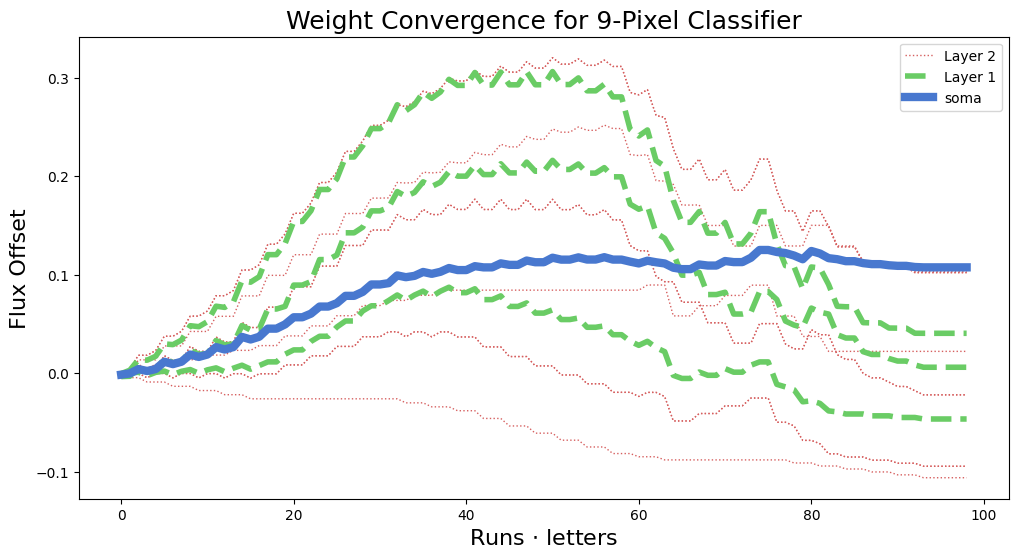

In [135]:
# Plot the offset trajectories for each dendrite to demonstrate convergence
import seaborn as sns
# colors = sns.color_palette('hls', 13)
# colors = sns.color_palette('seaborn-v0_8-muted', 13)

plt.style.use('seaborn-v0_8-muted')
# print(plt.__dict__['pcolor'].__doc__)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# plt.style.use('seaborn-v0_8-muted')
count1=0
count2=0
# plot trajectories of flux offsets for each dendrite
plt.figure(figsize=(12,6))
for i,(name,offset) in enumerate(reversed(offsets.items())):
    if 'soma' in name:
        name = 'soma'
        # plt.plot(offset,color=colors[i],label=name,linewidth=4)
        plt.plot(offset,color=colors[0],label=name,linewidth=6)
    elif 'lay1' in name:
        col = colors[1]

        if count1 == 0:
            plt.plot(offset,'--',color=col,linewidth=4,label='Layer 1')
        else:
            # plt.plot(offset,color=colors[0],label=name,linewidth=3)
            plt.plot(offset,'--',color=col,linewidth=4)
        count1+=1

    elif 'lay2' in name:
        col = colors[2]
        if count2 == 0:
            plt.plot(offset,':',color=col,label='Layer 2',linewidth=1)
        else:
            plt.plot(offset,':',color=col,linewidth=1)
        # plt.plot(offset,color=colors[4],label=name)
        count2+=1

plt.title("Weight Convergence for 9-Pixel Classifier",fontsize=18)
plt.xlabel("Runs $\cdot$ letters",fontsize=16)
plt.ylabel("Flux Offset",fontsize=16)
plt.legend()
plt.show()

***Flux Adjustments***

In the below plot, the dotted phi_r lines before the input is received at 20ns, show the amount by which flux has been offset for that neuron.  It can be seen that the combination of many small adjustments is sufficient to complete the learnign task.

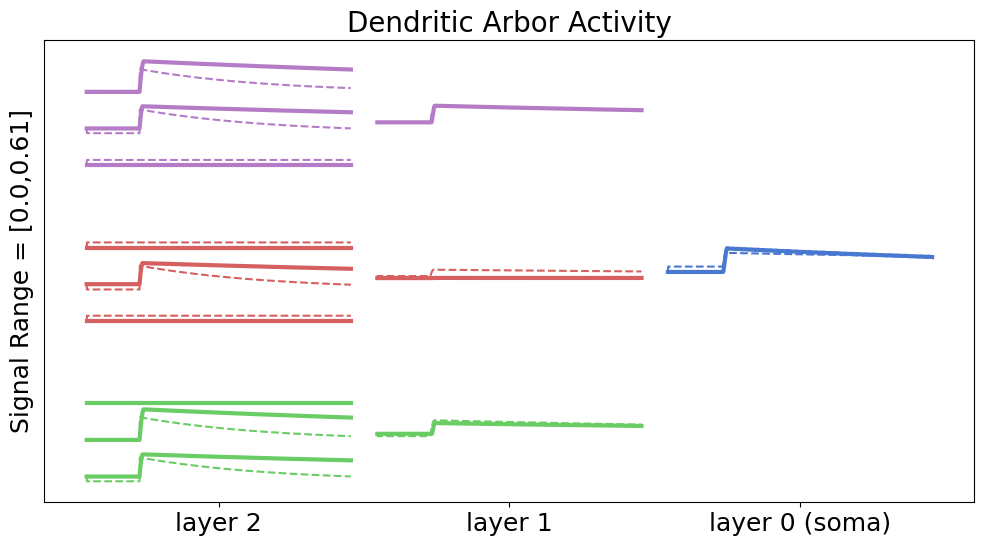

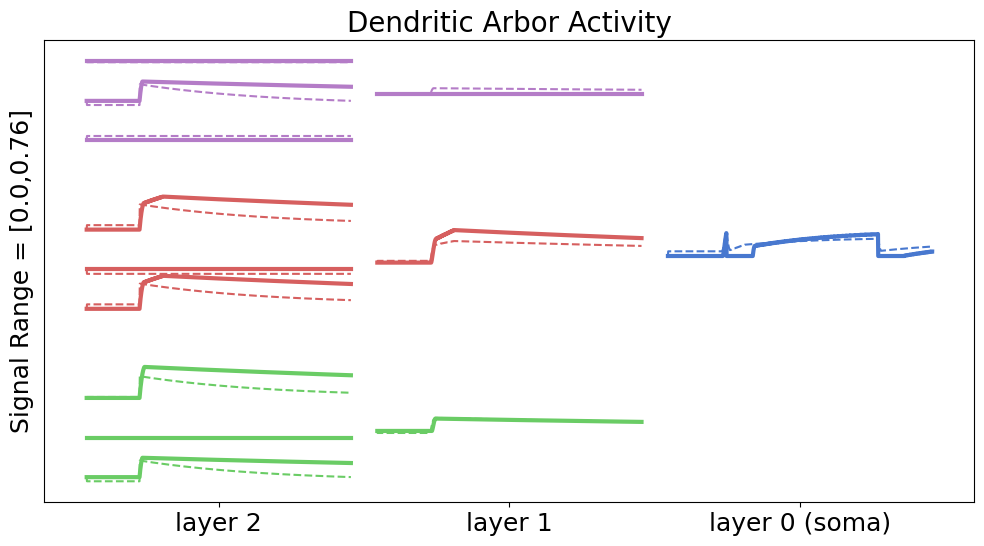

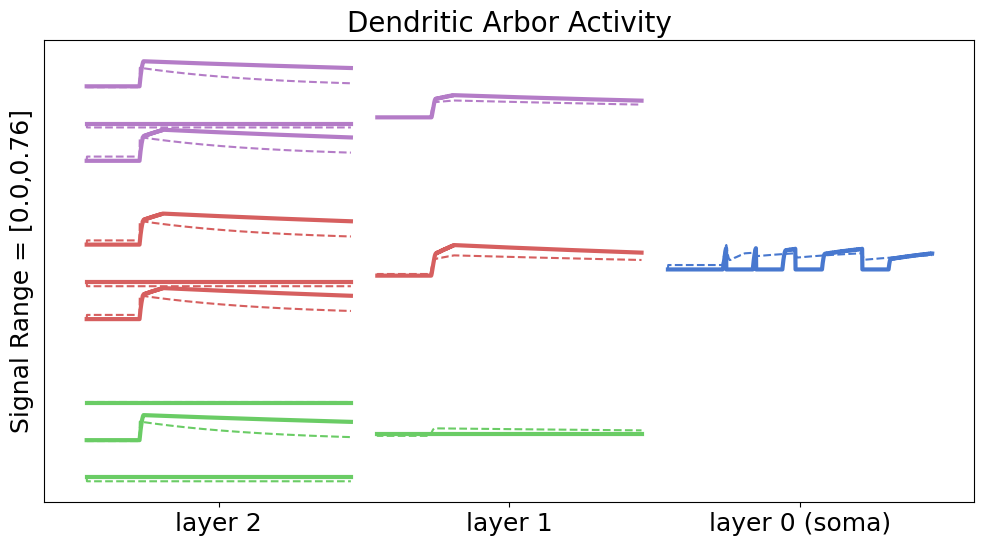

In [ ]:
# plot arbor activities
for i,n in enumerate(run_copies):
    n.plot_arbor_activity(net_copies[i],phir=True)

The above learning rule carries over to more complex (non-linear) tasks, such as 9-pixel classification with noise.  The version above is presented for simplicity's sake.

### Part 4: Networking and Dynamics

 - Equipped with powerful single-neuron computations, networking becomes the next step
 - Like `SuperNode`, `SuperNet` is a wrapper class that facilitates custom design (now of networks)
 - Pass in network params *and* node params (for the contained nodes) to quickly generate a custom network


Internal network connections = 45


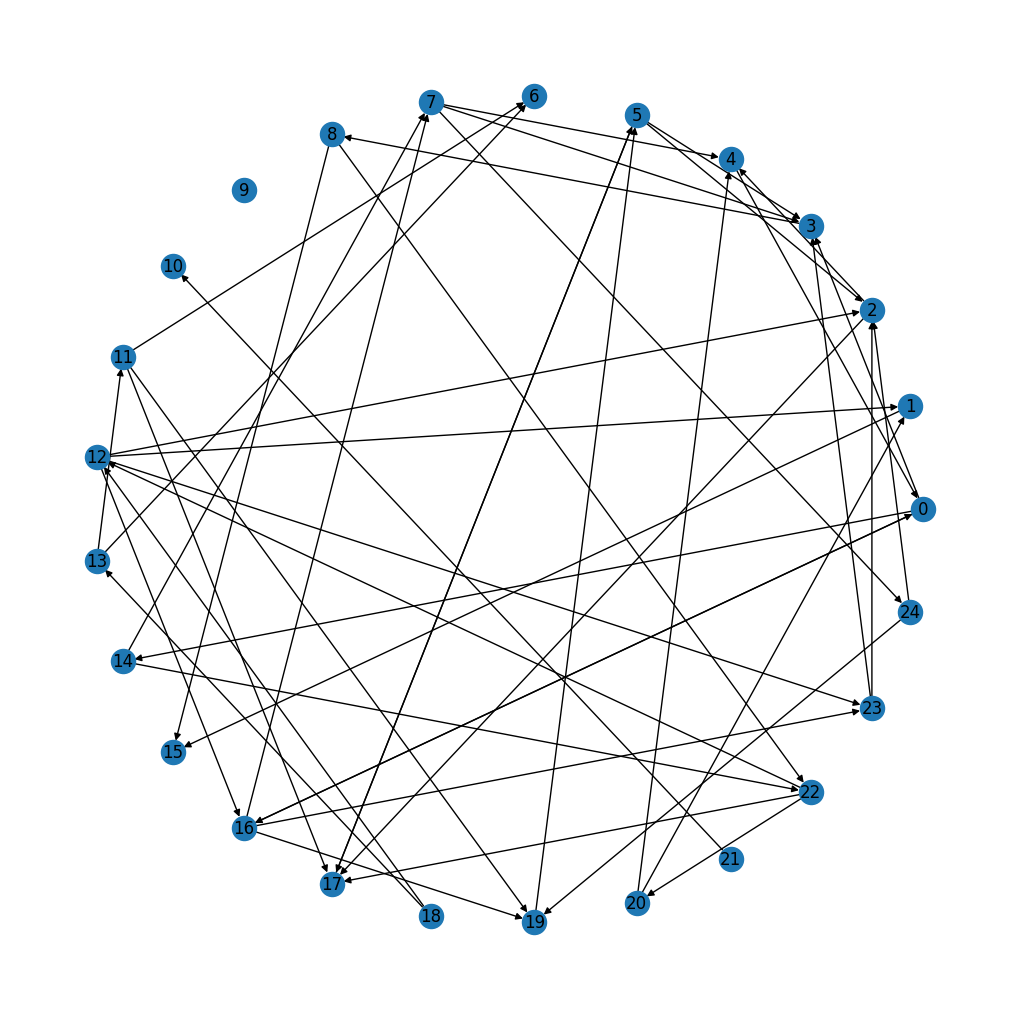

In [ ]:
from sim_soens.super_net import SuperNet

# define weights by layer
l1_w = .5
l2_w = .5

# call the 
net = SuperNet(

    N            = 25,  # number of neurons in network
    tf           = 500, # duration

    prob_connect = 0.1, # probability of internal connections
    # connectivity = [[12,1],[neuron_index,neuron_index],[m,n]...] # for specified connectivity
    
    # node parameters for within-network nodes (these are passed into SuperNode)
    # this is a list of all node designs desired
    node_params = [
    {
    "weights": [
    [[l1_w,l1_w]],
    [[l2_w,l2_w,l2_w],[l2_w,l2_w,l2_w]]
    ],
    "s_th": .5,
    },
    {
    "weights": [
    [[l1_w,l1_w]],
    [[l2_w,l2_w],[l2_w,l2_w]]
    ],
    "s_th": .5
    }
    ],

    # defines how many nodes of each of above specified type will be generated
    # indices correspond
    node_quantities = [20,5] 
)

# visualize your network
net.graph_net()


Input network connections = 0

running network


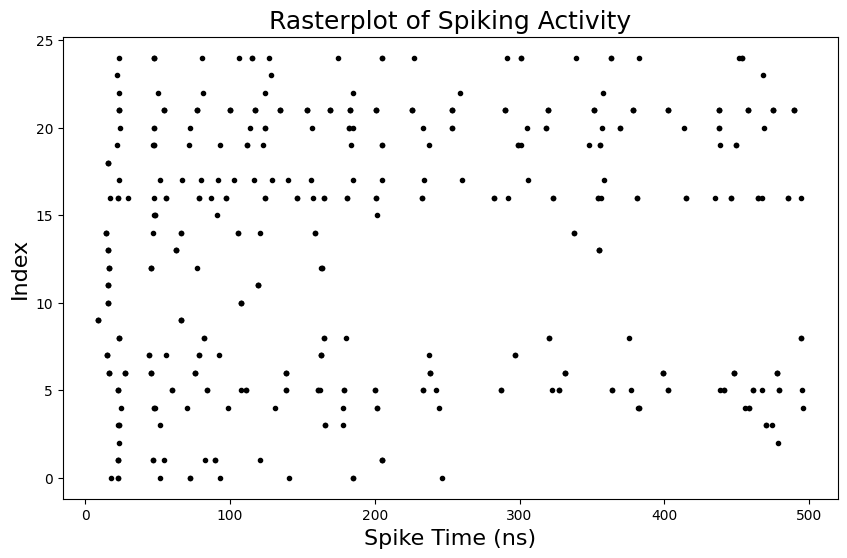

In [ ]:
input = SuperInput(channels=42, type='random', total_spikes=1000, duration=500)

# connect input 
net.input_connect(
    input,
    prob_input=1 # probability (if synapses available) of any input channel connecting to any neuron
    # in_connectivity = [[12,1],[input_index,neuron_index],[m,n]...] # for specified connectivity
    )

net.run_network()
net.raster_plot()


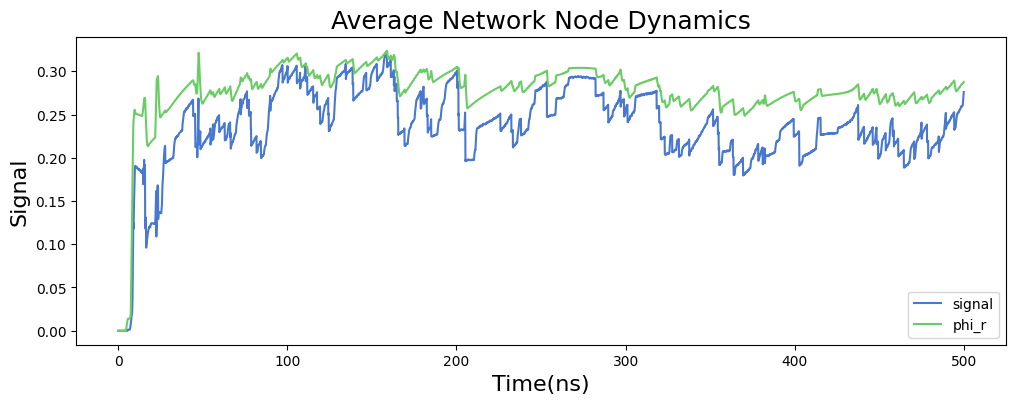

In [ ]:
# move to within class
plt.figure(figsize=(12,4))
plt.plot(net.net.t,np.mean(net.net.signal,axis=0),label="signal")
plt.plot(net.net.t,np.mean(net.net.phi_r,axis=0),label="phi_r")
plt.legend()
plt.xlabel("Time(ns)",fontsize=16)
plt.ylabel("Signal",fontsize=16)
plt.title("Average Network Node Dynamics",fontsize=18)
plt.show()

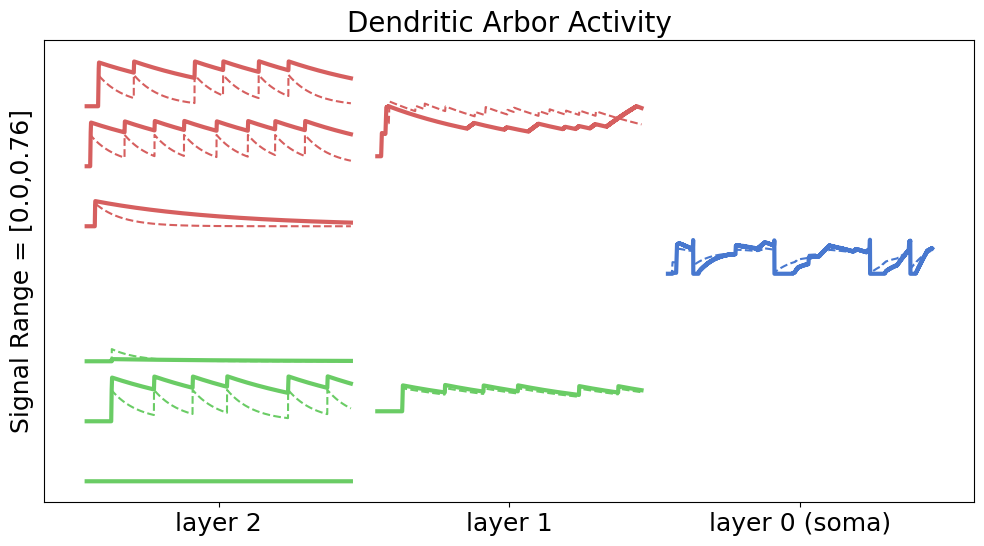

In [ ]:
# activity of a sample node
net.nodes[4].plot_arbor_activity(net.net,phir=True)

### Reservoir Computing
Here is a simple reservoir example, stricly to demonstrate "networkability."
 - Saccade MNIST dataset
 - Random reservoir of point neurons
 - Linear classifier trained on network activity

Note, on the Google Colab, *it may be better to not run these cells*, and rather take a look at output as is.

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


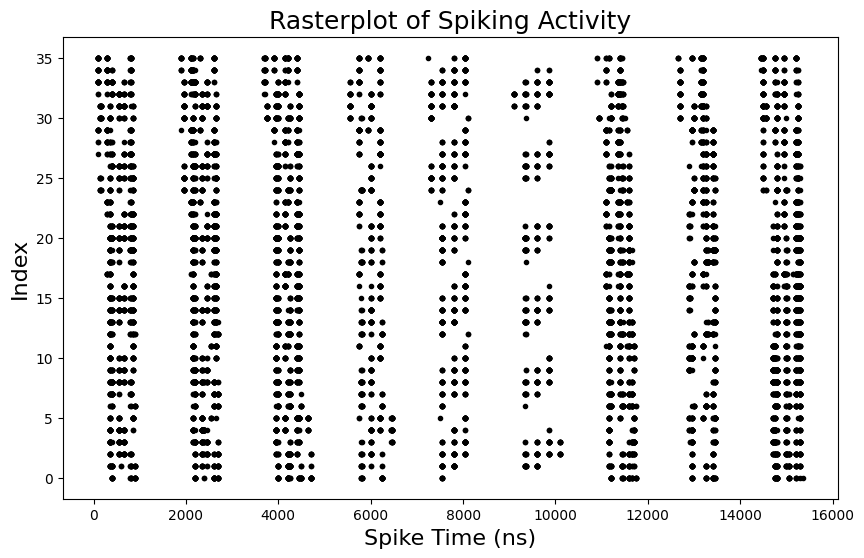

In [ ]:
# Saccade MNIST dataset
input = SuperInput(channels=36,type="saccade_MNIST",tile_time=50)
raster_plot(input.spike_arrays)

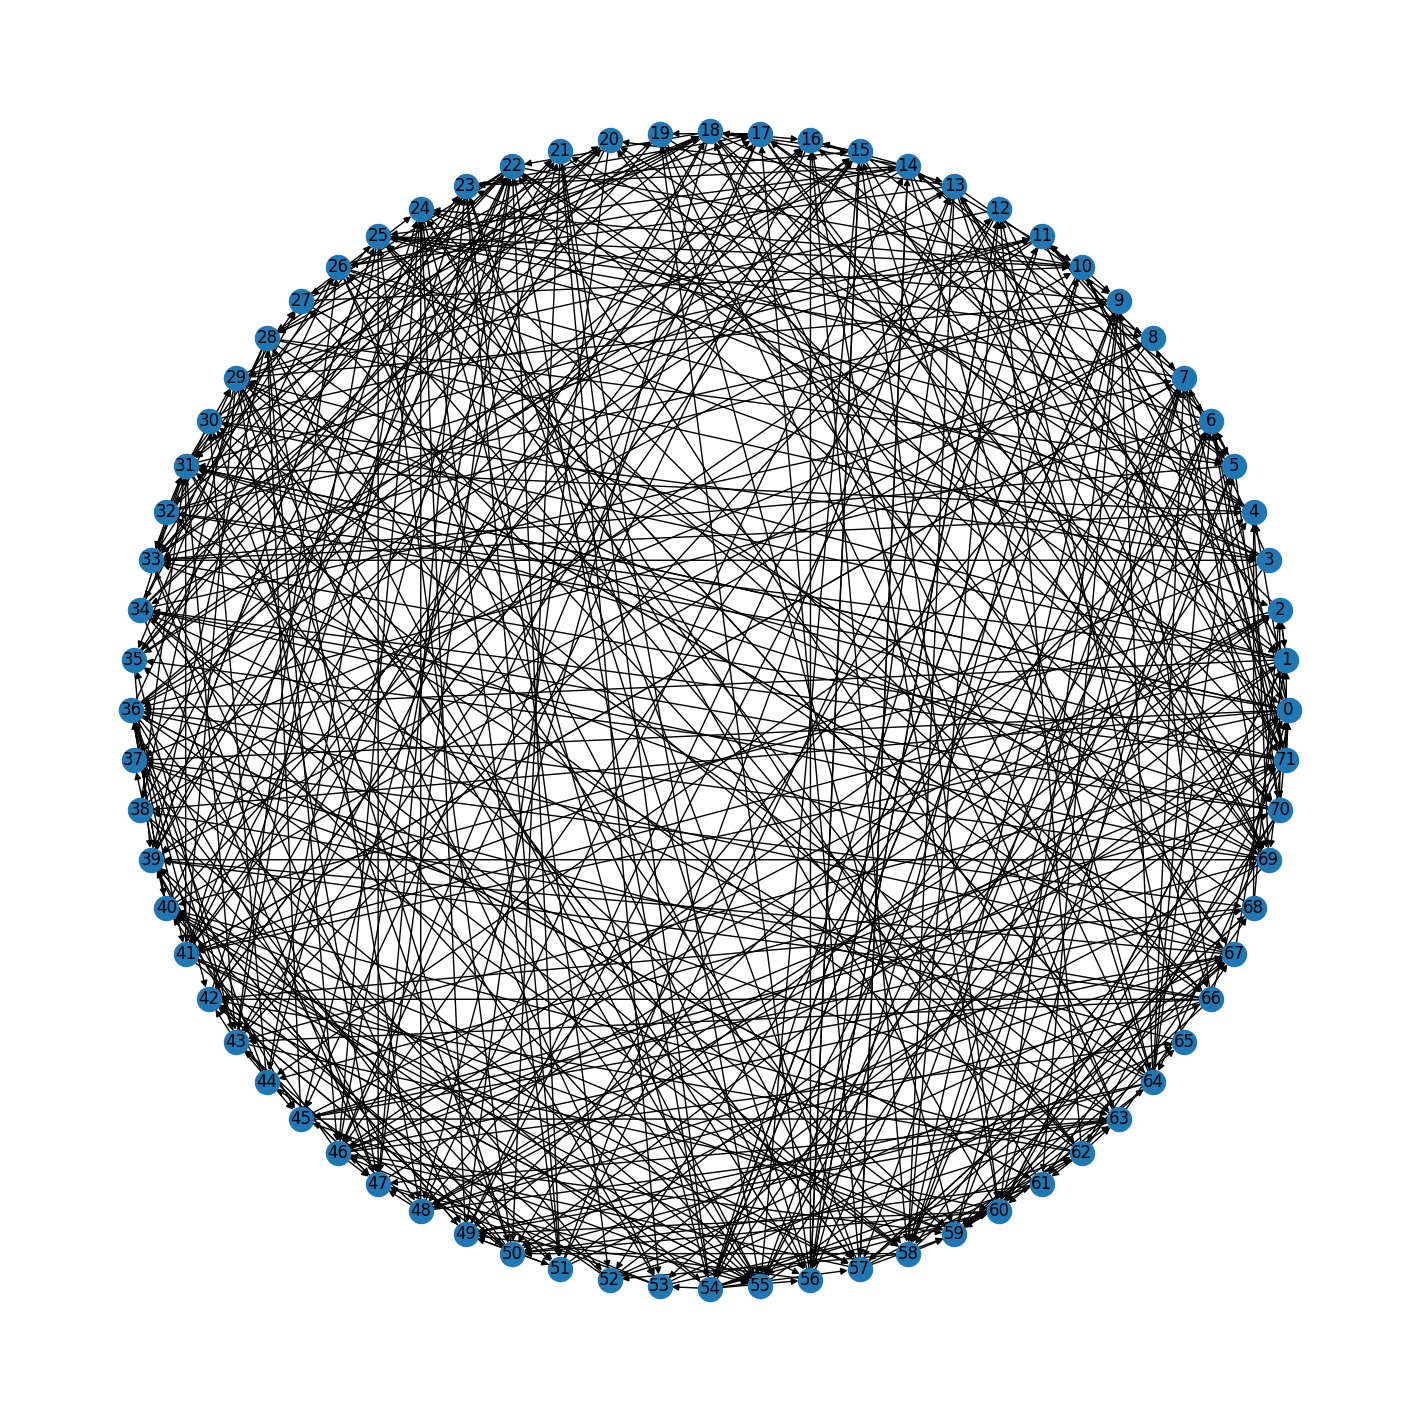

In [ ]:
# Random network of 72 neurons
from sim_soens.super_net import PointReservoir
params= {
    "N":72,
    "s_th":0.5,
    "beta":2*np.pi*10**2,
    "tau":100,
    "tau_ref":50,
    "tf":3600*5,
    "run":1,
    "laps":10,
    }

res = PointReservoir(**params)
res.graph_net()

In [ ]:
# Wire up input
res.connect_input(input)
# res.graph_input()

In [ ]:
# Run the network and plot activity
res.run_network()
# raster_plot(res.net.spikes)

[0 1 2]  --> Classified!


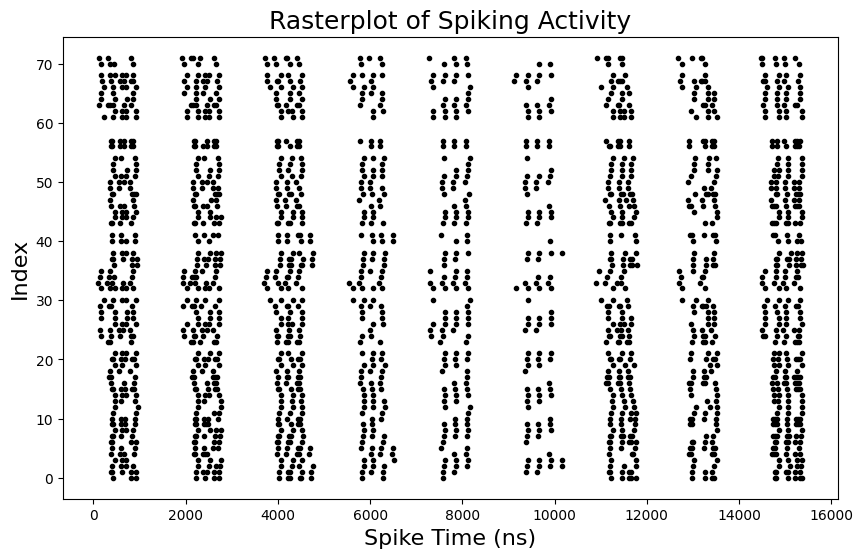

In [ ]:
# Train and test linear classifier!
from sim_soens.super_functions import *
from sklearn.linear_model import LogisticRegression
spikes = res.net.spikes
# spikes = input.spike_arrays

N = 72
T = 3601*5
classes = 3
examples_per_class = 3
samples = classes*examples_per_class
window = 360*5
labels = [0,0,0,1,1,1,2,2,2]

# spikes = net.net.spikes
mat = spks_to_binmatrix(N,T,spikes)
# raster_plot(spikes)
model = LogisticRegression(max_iter=100000)
X = []
y = []
X_f = []
y_f = []
for i in range(samples):
    if  i%3 != 2:
        section = mat[:,i*window:i*window+window]
        x = np.concatenate(section).reshape(1, -1)[0]
        X.append(x)
        y.append(labels[i])


model.fit(X,y)

X_test = []
y_test = []
for i in range(samples):
    if i%3 == 2:
        section = mat[:,i*window:i*window+window]
        x = np.concatenate(section).reshape(1, -1)[0]
        X_test.append(x)


predictions=model.predict(X_test)

if np.array_equal(predictions, [0,1,2]):
    print(predictions, " --> Classified!")
    raster_plot(spikes)
else:
    print(predictions)

# Thank you!

|Topic                    |Contact|
|-------------------------|-------|
|sim_soens, algorithms    | rmoloughlin11@gmail.com  |
|                         | ryan.oloughlin@nist.gov  |
|cicuits                  |bryce.primavera@nist.gov  |
|involvement opportunities|jeffrey.shainline@nist.gov|